In [432]:
import os
import sys
import glob
import scipy
import skbio
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
sns.set_style('white')
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42

from IPython.display import display, HTML
import tRep

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 200

### Load relevant tables

In [433]:
Ndb = pd.read_csv('/groups/banfield/projects/human/data3/clou/wastewater/Datasheets/Wastewater_DeltaCoverage_All_Viral_Genomes_v2b_SetMinBreadth.csv')
Ndb_raw = pd.read_csv('/groups/banfield/projects/human/data3/clou/wastewater/Datasheets/Wastewater_DeltaCoverage_All_Viral_Genomes_v2_AddRelativeAbundance.csv')
RMdb = pd.read_csv('/groups/banfield/projects/human/data3/clou/wastewater/Datasheets/Wastewater_ReadMapping_All_Viral_Genomes_v1.csv')

Gdb = pd.read_csv('/groups/banfield/projects/human/data3/clou/wastewater/Datasheets/metadata/viral_name_df.csv')
Rdb = pd.read_csv('/groups/banfield/projects/human/data3/clou/wastewater/Datasheets/waster_water_readDepths_formatted.csv')
Mdb = pd.read_csv('/groups/banfield/projects/human/data3/clou/wastewater/Datasheets/metadata/sample_metadata_v2_sample_name_adjusted.csv')

In [434]:
Ndb.head(2)

,sample,sample_complete_description,core,method,enrichment,subgroup,genome,length,relative_abundance (%),breadth,coverage,sample_read_bases,sample_reads,popANI_reference,conANI_reference,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,divergent_site_count,reads_unfiltered_reads,nucl_diversity,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,coverage_SEM,breadth_minCov,breadth_expected,nucl_diversity_rarefied,iRep,iRep_GC_corrected,linked_SNV_count,SNV_distance_mean,r2_mean,d_prime_mean,consensus_divergent_sites,population_divergent_sites,SNS_count,SNV_count
0,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Tomato_mosaic_virus-tax12253-GCF_000853705.1_ViralProj14926_genomic.fna,6383.0,0.116825,0.436002,0.950337,6107540,82174,1.000000,0.995833,48,67,0.974626,1.0,136,0.003333,1.0,1.0,0,1.602238,0.020378,0.037600,0.567921,0.0,NaN,False,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0
1,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Tomato_brown_rugose_fruit_virus-tax1761477-GCF_001461485.1_ViralProj304915_genomic.fna,6393.0,1.591744,0.936806,13.321758,6107540,82174,0.999802,0.999207,654,743,0.990614,33.0,1524,0.004306,1.0,1.0,11,11.393603,0.144792,0.788675,0.999992,0.0,1.607168,False,20.0,7.95,0.515256,0.97197,4.0,1.0,1.0,32.0


In [435]:
sample2core = dict(zip(Ndb['sample'],Ndb['core']))
sample2description = dict(zip(Ndb['sample'],Ndb['sample_complete_description']))
sample2enrichment = dict(zip(Ndb['sample'],Ndb['enrichment']))
sample2method = dict(zip(Ndb['sample'],Ndb['method']))
sample2subgroup = dict(zip(Ndb['sample'],Ndb['subgroup']))

### plot abundance

In [436]:
from cycler import cycler

colors = []
for i,c in enumerate(plt.get_cmap('tab20b').colors):
    colors.append(c)
for i,c in enumerate(plt.get_cmap('tab20c').colors):
    colors.append(c)
for i,c in enumerate(plt.get_cmap('Set3').colors):
    colors.append(c)
print(len(colors))

52


In [437]:
def simple_stacks_v4(data, x, y, hue, palette = False, size = (5, 3), \
                    xlim = False, ylim = False, xtitle='', ytitle='',\
                    width = 0.75, title='', save=False, order=False, xorder=False):
    """
    plot stacked bar chart
    * v4 = legend only shows genomes with relative_abundance > 0
    """

    # legend
    plt.legend(loc='best', prop = {'size': 10})
    
    
    if order == False:
        df = data[data['relative_abundance (%)'] > 0]
        # order to plot each item based on most abundant first
        items = set(df[hue]) # all hues (genomes)
        items = [(sum([i for i in df[df[hue] == s][y].values\
                       if type(i) is float]), s) for s in items] # (sum of values, hue)
        items = [i[1] for i in sorted(items, reverse = True)] # hues ordered by sum
    else:
        df = data[data['relative_abundance (%)'] > 0]
        assert set(order) == set(df[hue])
        assert len(set(order)) == len(order)
        items = order

    #print(items)
        
    # values
    if xorder == False:
        X_labels = sorted(list(set(data[x]))) # All x labels
    else:
        assert set(xorder) == set(data[x])
        X_labels = xorder
    X = list(range(0, len(X_labels))) # range of x labels

    # count data for plotting
    running = [0 for i in X]
    Iabundance = [] # [hue, [sum(hue) for every x + previous hues], [sum(hue) for every x ]]
    for s in items:
        hdb = data[data[hue] == s] # dataframe with only this hue (s)
        abundance = [] # list of the abundance of values for this hue
        for xi in X_labels:
            a = np.nan_to_num(hdb[hdb[x] == xi][y].values) # all values of this hue + x
            if len(a) == 0:
                abundance.append(0)
            else:
                a = [i for i in a if type(i) is not str]
                abundance.append(np.nansum(a)) # append all values

        running = [i + j for i, j in zip(running, abundance)] # this hue + all previous hues
        Iabundance.append([s, running, abundance])

    # plot abundance
    for s, running, abundance in Iabundance[::-1]:
#         s = hue, running = [sum(x) + previous for x in hue]
        if palette == False:
            plt.rc('axes', prop_cycle=cycler('color', colors))
            
            ax = plt.bar(X, running, \
                       label = s,\
                       width = width, alpha = 1, linewidth=0)
        else:
            plt.bar(X, running, \
                    label = s, color = palette[s],\
                    width = width, alpha = 1, linewidth=0)
    
    X_labels = [(i,'Mom')[i == 0] for i in X_labels]
    plt.xticks([xi for xi in X], X_labels,rotation=90)

    # legend
    plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.4), \
            prop = {'size': 10, 'style': 'italic'})

    # ylim
    if ylim != False:
        plt.ylim(0,ylim)

    # xlim
    plt.xlim(-1, len(X_labels))

    # title
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)

    # save
    if save != False:
        plt.savefig(str(save) + ".pdf",format="pdf",transparent=True, bbox_inches='tight')

In [438]:
# check overall relative abundance per sample

table = defaultdict(list)
for s,sdb in Ndb.groupby('sample'):
    total_reads_perc = sdb['relative_abundance (%)'].sum()
    
    table['sample'].append(s)
    table['total_reads_perc'].append(total_reads_perc)
    
rdb = pd.DataFrame(table)
rdb['sample_complete_description'] = rdb['sample'].map(sample2description)
rdb['subgroup'] = rdb['sample'].map(sample2subgroup)
rdb['core'] = rdb['sample'].map(sample2core)
rdb = rdb.sort_values(['total_reads_perc']).reset_index(drop=True)
rdb

,sample,total_reads_perc,sample_complete_description,subgroup,core
0,p630-N,0.068843,p630-N_ILLUMINA,Illumina_enriched,ILLUMINA
1,SQ1,0.091375,SQ1_ILLUMINA,Illumina_unenriched,ILLUMINA
2,SQ2,0.098291,SQ2_ILLUMINA,Illumina_unenriched,ILLUMINA
3,630-S2,0.225993,630-S2_ILLUMINA,Illumina_unenriched,ILLUMINA
4,S68-1,0.239689,S68-1_ILLUMINA,Illumina_unenriched,ILLUMINA
5,630-N,0.292237,630-N_ILLUMINA,Illumina_unenriched,ILLUMINA
6,p630-SF1,0.329318,p630-SF1_ILLUMINA,Illumina_enriched,ILLUMINA
7,630-SF1,0.333708,630-SF1_ILLUMINA,Illumina_unenriched,ILLUMINA
8,MR3,0.333886,MR3_ILLUMINA,Illumina_unenriched,ILLUMINA
9,MR2,0.357550,MR2_ILLUMINA,Illumina_unenriched,ILLUMINA


### Plot top10 most abundant genomes for each of the four sequencing groups

In [439]:
tables = []
for s,sdb in Ndb.groupby('sample'):
    sdb = sdb.sort_values('relative_abundance (%)',ascending=False)
    sdb_top10 = sdb.head(10)
    tables.append(sdb_top10)
Ndb2 = pd.concat(tables)
Ndb2 = Ndb2.reset_index(drop=True)
Ndb2

,sample,sample_complete_description,core,method,enrichment,subgroup,genome,length,relative_abundance (%),breadth,coverage,sample_read_bases,sample_reads,popANI_reference,conANI_reference,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,divergent_site_count,reads_unfiltered_reads,nucl_diversity,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,coverage_SEM,breadth_minCov,breadth_expected,nucl_diversity_rarefied,iRep,iRep_GC_corrected,linked_SNV_count,SNV_distance_mean,r2_mean,d_prime_mean,consensus_divergent_sites,population_divergent_sites,SNS_count,SNV_count
0,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Tomato_brown_rugose_fruit_virus-tax1761477-GCF_001461485.1_ViralProj304915_genomic.fna,6393.0,1.591744,0.936806,13.321758,6107540,82174,0.999802,0.999207,654,743,0.990614,33.0,1524,0.004306,1.0,1.0,11,11.393603,0.144792,0.788675,0.999992,0.000000,1.607168,False,20.0,7.950000,0.515256,0.971970,4.0,1.0,1.0,32.0
1,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_2-tax2697049-GCF_009858895.2_ASM985889v3_genomic.fna,29903.0,1.445713,0.704979,2.508344,6107540,82174,0.999827,0.999482,594,662,0.988274,8.0,1377,0.004077,1.0,1.0,1,3.323712,0.019285,0.193860,0.890832,0.000000,NaN,False,NaN,NaN,NaN,NaN,3.0,1.0,1.0,7.0
2,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Tomato_mosaic_virus-tax12253-GCF_000853705.1_ViralProj14926_genomic.fna,6383.0,0.116825,0.436002,0.950337,6107540,82174,1.000000,0.995833,48,67,0.974626,1.0,136,0.003333,1.0,1.0,0,1.602238,0.020378,0.037600,0.567921,0.000000,NaN,False,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0
3,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Pepper_mild_mottle_virus_strain_S-tax12239-GCF_000859645.1_ViralProj15148_genomic.fna,6357.0,0.058413,0.339626,0.495989,6107540,82174,0.000000,0.000000,24,30,0.974398,0.0,61,NaN,1.0,1.0,0,0.776961,0.009903,0.000000,0.354647,NaN,NaN,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Wuhan_insect_virus_23_strain_WHCCII13263-tax1923727-GCF_001921615.1_ViralMultiSegProj358547_genomic.fna,2858.0,0.051111,0.479356,0.939468,6107540,82174,1.000000,1.000000,21,28,0.969949,0.0,56,0.000000,2.0,2.0,1,1.296242,0.026151,0.013296,0.563755,0.000000,NaN,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,pSQ2,pSQ2_ILLUMINA,ILLUMINA,MOS & COL,enriched,Illumina_enriched,Severe_acute_respiratory_syndrome_coronavirus_2-tax2697049-GCF_009858895.2_ASM985889v3_genomic.fna,29903.0,14.236542,0.701970,4979.995853,1010081054,14005704,0.998414,0.998126,996964,1043166,0.997563,72.0,3061737,0.001374,1.0,1.0,2962,6815.093249,39.543851,0.695984,1.000000,0.001237,2.546182,False,57.0,44.666667,0.517487,0.904007,39.0,33.0,33.0,39.0
283,pSQ2,pSQ2_ILLUMINA,ILLUMINA,MOS & COL,enriched,Illumina_enriched,Tomato_brown_rugose_fruit_virus-tax1761477-GCF_001461485.1_ViralProj304915_genomic.fna,6393.0,0.028374,0.877366,45.930862,1010081054,14005704,0.998573,0.997681,1987,2632,0.997079,30.0,5454,0.001613,1.0,1.0,37,43.645683,0.554659,0.877053,1.000000,0.001194,NaN,False,6.0,6.166667,0.573476,1.000000,13.0,8.0,8.0,22.0
284,pSQ2,pSQ2_ILLUMINA,ILLUMINA,MOS & COL,enriched,Illumina_enriched,Cucumber_green_mottle_mosaic_virus_strain_SH-tax12235-GCF_000849225.1_ViralProj14681_genomic.fna,6424.0,0.019763,0.855542,31.806351,1010081054,14005704,0.985368,0.984983,1384,1793,0.985378,92.0,4166,0.001427,1.0,1.0,21,34.210298,0.433668,0.808531,1.000000,0.000944,NaN,False,8.0,27.875000,0.594470,1.000000,78.0,76.0,76.0,16.0
285,pSQ2,pSQ2_ILLUMINA,ILLUMINA,MOS & COL,enriched,Illumina_enriched,uncultured_crAssphage-tax1211417-GCF_000922395.1_ViralProj259336_genomic.fna,97065.0,0.011467,0.122907,1.223974,1010081054,14005704,0.987179,0.986958,803,1006,0.985908,125.0,2573,0.000986,1.0,1.0,0,4.188498,0.013458,0.093216,0.660665,

In [440]:
genome2color = dict(zip(Ndb2.sort_values('genome')['genome'].unique().tolist(), colors))
print(len(Ndb2['genome'].unique()))

37


No handles with labels found to put in legend.


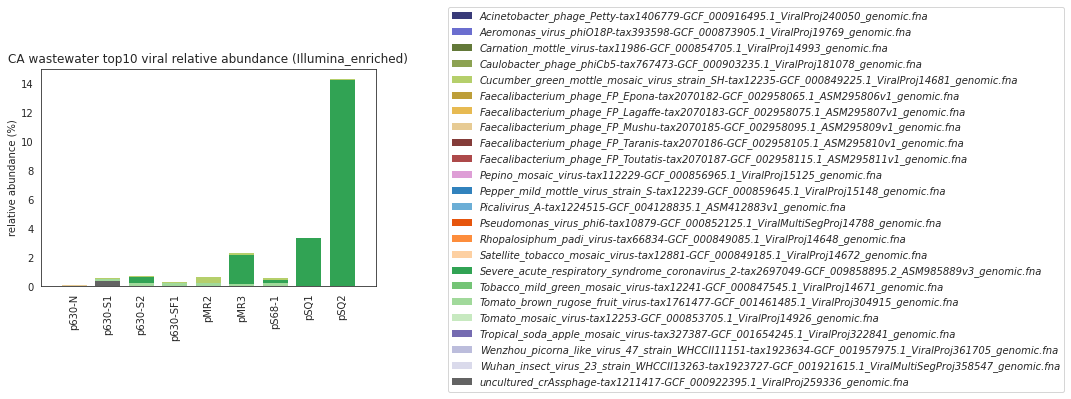

No handles with labels found to put in legend.


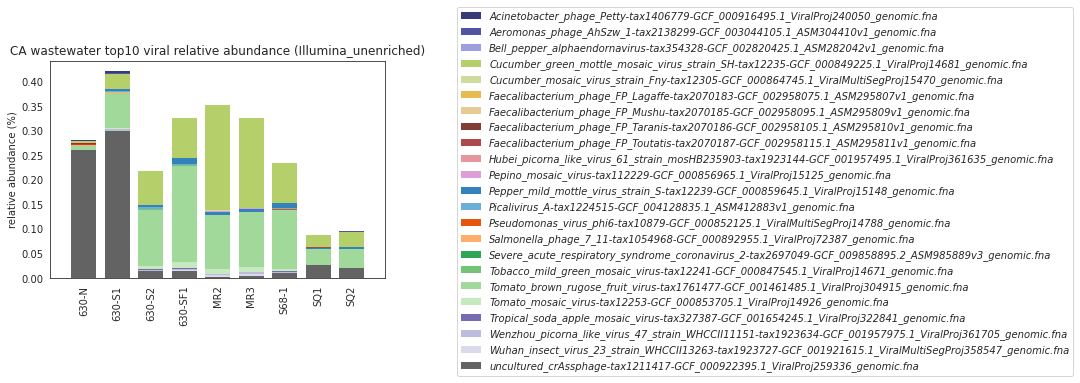

No handles with labels found to put in legend.


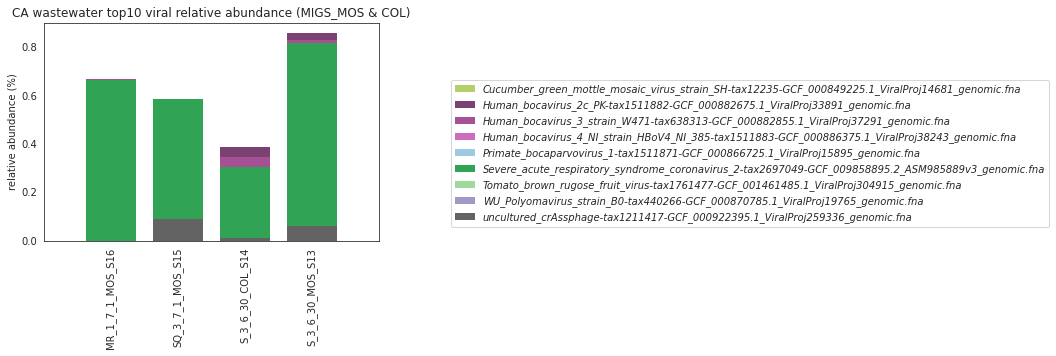

No handles with labels found to put in legend.


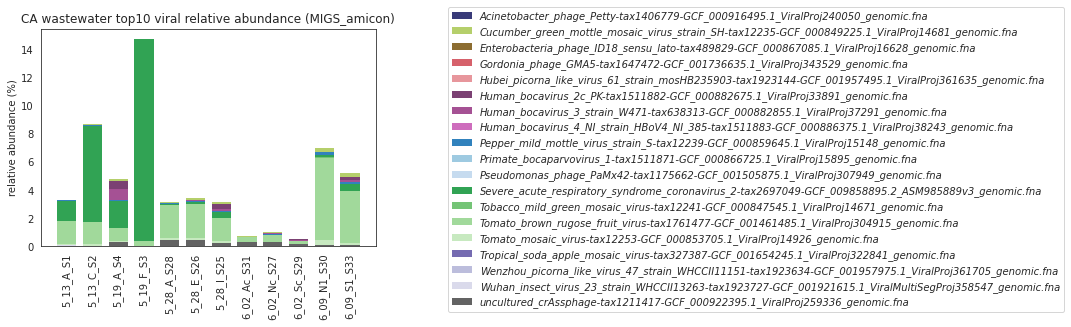

In [441]:
for sg,sgdb in Ndb2.groupby('subgroup'):
    simple_stacks_v4(sgdb, 'sample', 'relative_abundance (%)', 'genome', \
                 title="CA wastewater top10 viral relative abundance ({})".format(sg), palette=genome2color,\
                 size=(10,3))
    plt.ylabel('relative abundance (%)')
    plt.show()

### Plot only SARS-CoV2

In [442]:
Ndb_covid19 = Ndb[Ndb['genome'].str.contains('Severe_acute_respiratory_syndrome_coronavirus')]

Ndb_covid19

,sample,sample_complete_description,core,method,enrichment,subgroup,genome,length,relative_abundance (%),breadth,coverage,sample_read_bases,sample_reads,popANI_reference,conANI_reference,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,divergent_site_count,reads_unfiltered_reads,nucl_diversity,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,coverage_SEM,breadth_minCov,breadth_expected,nucl_diversity_rarefied,iRep,iRep_GC_corrected,linked_SNV_count,SNV_distance_mean,r2_mean,d_prime_mean,consensus_divergent_sites,population_divergent_sites,SNS_count,SNV_count
2,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_2-tax2697049-GCF_009858895.2_ASM985889v3_genomic.fna,29903.0,1.445713,0.704979,2.508344,6107540,82174,0.999827,0.999482,594,662,0.988274,8.0,1377,0.004077,1.0,1.0,1,3.323712,0.019285,0.193860,0.890832,0.000000,NaN,False,NaN,NaN,NaN,NaN,3.0,1.0,1.0,7.0
8,5_13_C_S2,5_13_C_S2_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_2-tax2697049-GCF_009858895.2_ASM985889v3_genomic.fna,29903.0,6.800861,0.944220,3.716851,1796238,24144,0.999882,0.999882,821,888,0.993680,1.0,1796,0.002344,1.0,1.0,3,2.810959,0.016310,0.283283,0.962446,0.000000,NaN,False,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0
11,5_19_A_S4,5_19_A_S4_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_2-tax2697049-GCF_009858895.2_ASM985889v3_genomic.fna,29903.0,1.937352,0.997927,14.679631,25431914,343252,0.999930,0.999789,3325,3642,0.991737,88.0,7462,0.002793,1.0,1.0,14,7.519903,0.043633,0.949470,0.999998,0.000000,1.691232,False,36.0,7.583333,0.892179,1.000000,6.0,2.0,2.0,86.0
27,5_19_F_S3,5_19_F_S3_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_2-tax2697049-GCF_009858895.2_ASM985889v3_genomic.fna,29903.0,14.370810,0.998228,111.809250,24851304,334748,0.999832,0.999765,24053,25013,0.996116,24.0,50686,0.001716,1.0,1.0,111,28.939932,0.167921,0.996121,1.000000,0.001738,1.419377,False,9.0,1.777778,0.732197,0.814462,7.0,5.0,5.0,19.0
31,5_28_A_S28,5_28_A_S28_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_2-tax2697049-GCF_009858895.2_ASM985889v3_genomic.fna,29903.0,0.023507,0.231616,0.470789,71023874,978422,0.994495,0.994495,115,138,0.984694,3.0,281,0.003955,1.0,1.0,0,1.096183,0.006360,0.018226,0.340126,0.000000,NaN,False,NaN,NaN,NaN,NaN,3.0,3.0,3.0,0.0
63,5_28_E_S26,5_28_E_S26_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_2-tax2697049-GCF_009858895.2_ASM985889v3_genomic.fna,29903.0,0.145462,0.783333,3.045781,72838764,1009198,0.999559,0.998825,734,870,0.984624,22.0,1824,0.003522,1.0,1.0,2,3.377169,0.019596,0.227669,0.932080,0.000000,NaN,False,NaN,NaN,NaN,NaN,8.0,3.0,3.0,19.0
77,5_28_I_S25,5_28_I_S25_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_2-tax2697049-GCF_009858895.2_ASM985889v3_genomic.fna,29903.0,0.461996,0.994315,12.160419,89771642,1248062,0.999882,0.999803,2883,3365,0.986816,134.0,6965,0.004601,1.0,1.0,10,9.446424,0.054812,0.849547,0.999978,0.004111,NaN,False,21.0,12.523810,0.709119,1.000000,5.0,3.0,3.0,131.0
311,6_02_Ac_S31,6_02_Ac_S31_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_2-tax2697049-GCF_009858895.2_ASM985889v3_genomic.fna,29903.0,0.005317,0.135873,0.215029,135654468,1880856,1.000000,1.000000,50,59,0.988460,0.0,118,0.000000,1.0,1.0,0,0.643821,0.003736,0.001605,0.172934,0.000000,NaN,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
331,6_02_Nc_S27,6_02_Nc_S27_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_2-tax2697049-GCF_009858895.2_ASM985889v3_genomic.fna,29903.0,0.011221,0.276728,0.497776,149433644,2067544,1.000000,1.000000,116,130,0.990374,0.0,263,0.000608,1.0,1.0,0,1.040696,0.006039,0.015283,0.355665,0.000000,NaN,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
339,6_02_Sc_S29,6_02_Sc_S29_MIGS,MIGS,amicon,enriched,MIGS_a

No handles with labels found to put in legend.


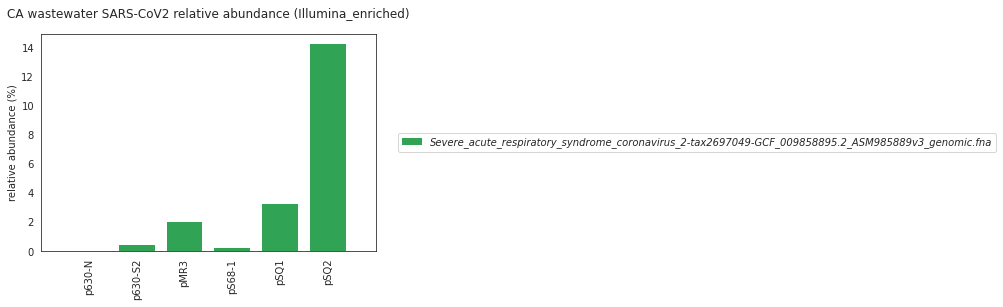

No handles with labels found to put in legend.


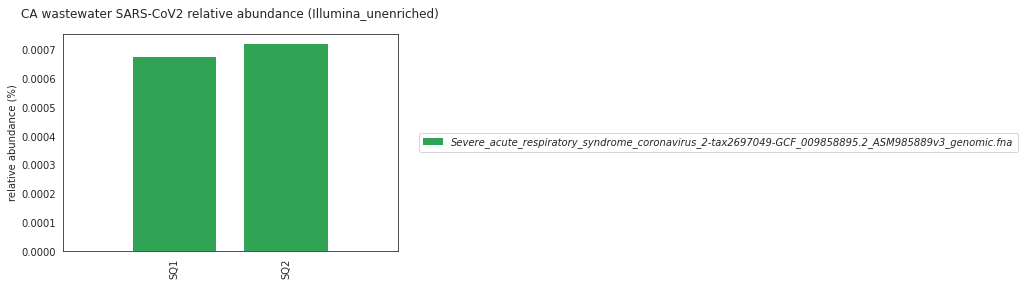

No handles with labels found to put in legend.


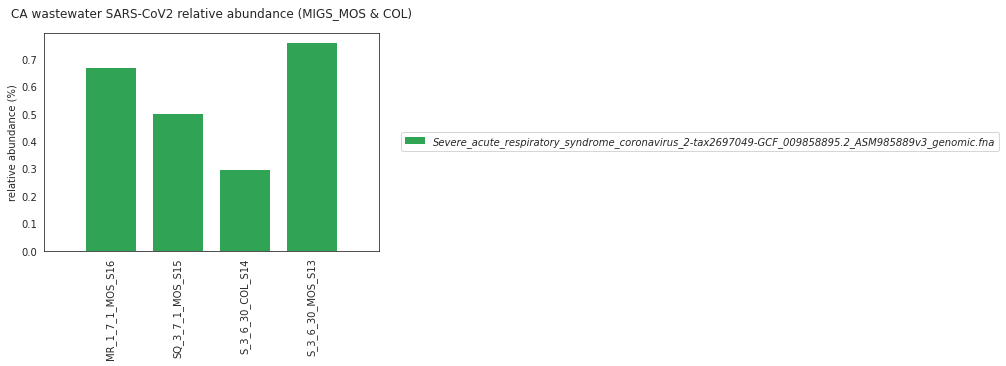

No handles with labels found to put in legend.


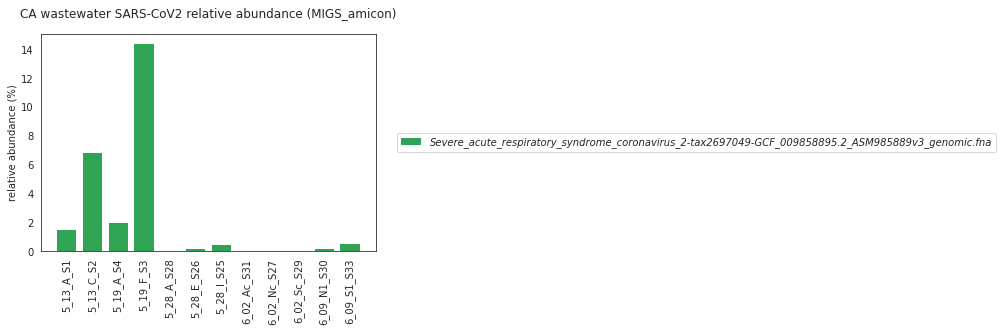

In [443]:
for g,gdb in Ndb_covid19.groupby('core'):
    for sg,sgdb in gdb.groupby('subgroup'):
        simple_stacks_v4(sgdb, 'sample', 'relative_abundance (%)', 'genome', \
                     title="CA wastewater SARS-CoV2 relative abundance ({})".format(sg), palette=genome2color,\
                     size=(10,3))
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), \
                    prop = {'size': 10, 'style': 'italic'})
        plt.title("CA wastewater SARS-CoV2 relative abundance ({})".format(sg),y=1.05)
        plt.ylabel('relative abundance (%)')
        plt.show()

In [444]:
def simple_stacks_v5(data, x, y, hue, palette = False, size = (5, 3), \
                    xlim = False, ylim = False, xtitle='', ytitle='',\
                    width = 0.75, title='', save=False, order=False, xorder=False):
    """
    plot stacked bar chart
    * v5 = allow to use this function to do subplots
    """

    # legend
    plt.legend(loc='best', prop = {'size': 10})
    
    
    if order == False:
        df = data[data['relative_abundance (%)'] > 0]
        # order to plot each item based on most abundant first
        items = set(df[hue]) # all hues (genomes)
        items = [(sum([i for i in df[df[hue] == s][y].values\
                       if type(i) is float]), s) for s in items] # (sum of values, hue)
        items = [i[1] for i in sorted(items, reverse = True)] # hues ordered by sum
    else:
        df = data[data['relative_abundance (%)'] > 0]
        assert set(order) == set(df[hue])
        assert len(set(order)) == len(order)
        items = order

        
    # values
    if xorder == False:
        X_labels = sorted(list(set(data[x]))) # All x labels
    else:
        assert set(xorder) == set(data[x])
        X_labels = xorder
    X = list(range(0, len(X_labels))) # range of x labels

    # count data for plotting
    running = [0 for i in X]
    Iabundance = [] # [hue, [sum(hue) for every x + previous hues], [sum(hue) for every x ]]
    for s in items:
        hdb = data[data[hue] == s] # dataframe with only this hue (s)
        abundance = [] # list of the abundance of values for this hue
        for xi in X_labels:
            a = np.nan_to_num(hdb[hdb[x] == xi][y].values) # all values of this hue + x
            if len(a) == 0:
                abundance.append(0)
            else:
                a = [i for i in a if type(i) is not str]
                abundance.append(np.nansum(a)) # append all values

        running = [i + j for i, j in zip(running, abundance)] # this hue + all previous hues
        Iabundance.append([s, running, abundance])

    # plot abundance
    for s, running, abundance in Iabundance[::-1]:
#         s = hue, running = [sum(x) + previous for x in hue]
        if palette == False:
            plt.rc('axes', prop_cycle=cycler('color', colors))
            
            ax.bar(X, running, \
                   label = s,\
                   width = width, alpha = 1, linewidth=0)
        else:
            ax.bar(X, running, \
                    label = s, color = palette[s],\
                    width = width, alpha = 1, linewidth=0)
    ax.set_xticks([xi for xi in X])
    ax.set_xticklabels(X_labels,rotation=90)
    
#     plt.xticks([xi for xi in X], X_labels,rotation=90)
#     ax.set_xticklabels([xi for xi in X], X_labels, rotation=90)

    # legend
#     plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.8), \
#             prop = {'size': 10, 'style': 'italic'})

    # ylim
    if ylim != False:
        plt.ylim(0,ylim)

    # xlim
    plt.xlim(-1, len(X_labels))

    # title
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)

    # save
    if save != False:
        plt.savefig(str(save) + ".svg",format="svg",transparent=True, bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


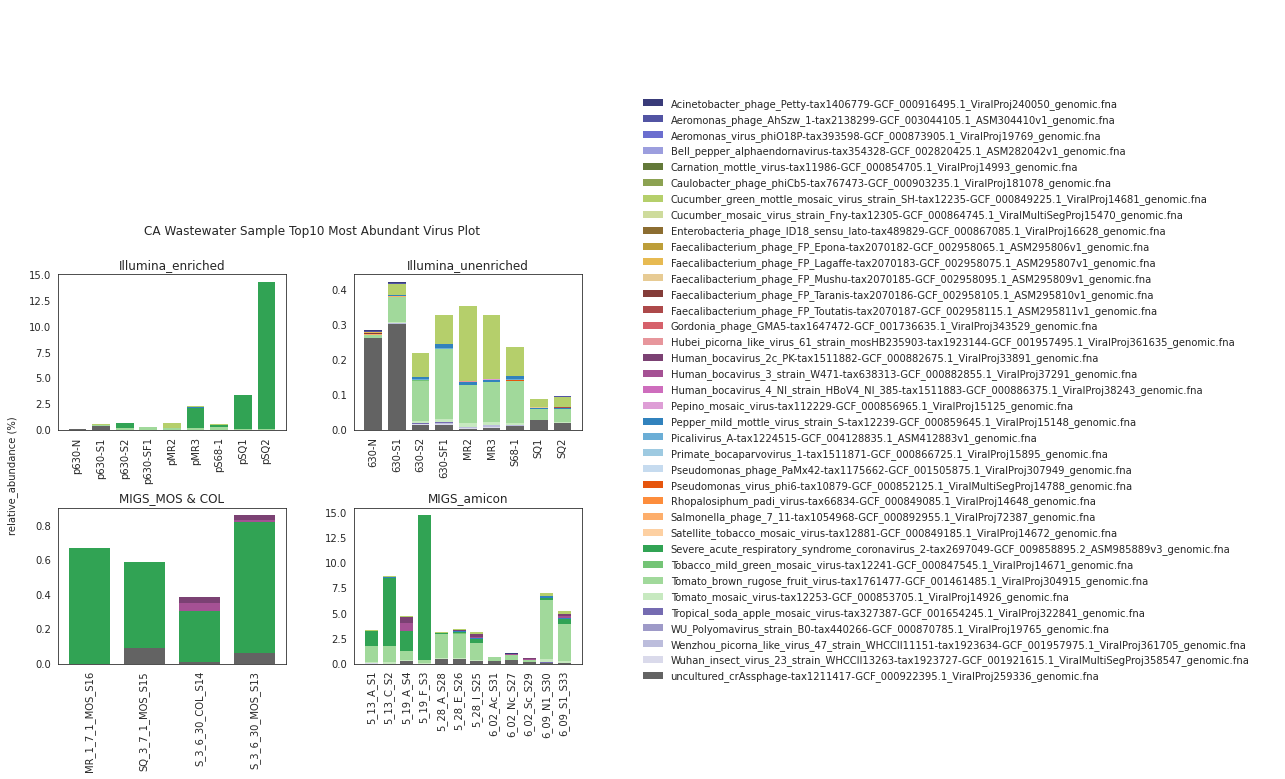

In [445]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(8,6))
fig.tight_layout()
fig.subplots_adjust(hspace=.5,wspace = 0.3)
fig.suptitle('CA Wastewater Sample Top10 Most Abundant Virus Plot',y=1.08)

for (name, sgdb), ax in zip(Ndb2.groupby('subgroup'), axes.flatten()):
    simple_stacks_v5(sgdb, 'sample', 'relative_abundance (%)', 'genome', \
                     title="{}".format(name), palette=genome2color,\
                     size=(10,3))
    ax.set(title=name)
ax.get_legend().remove()

handles = []
labels = []
for ax in fig.axes:
    axHandles, axLabels = ax.get_legend_handles_labels()
    handles.extend(axHandles)
    labels.extend(axLabels)
by_label = dict(zip(labels, handles))

from collections import OrderedDict
by_label_sorted = OrderedDict(sorted(by_label.items())) 
fig.legend(by_label_sorted.values(), by_label_sorted.keys(), loc='center left',bbox_to_anchor=(1.1, 0.9),frameon=False)

fig.text(-0.03, 0.5, 'relative_abundance (%)', va='center', rotation='vertical');

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


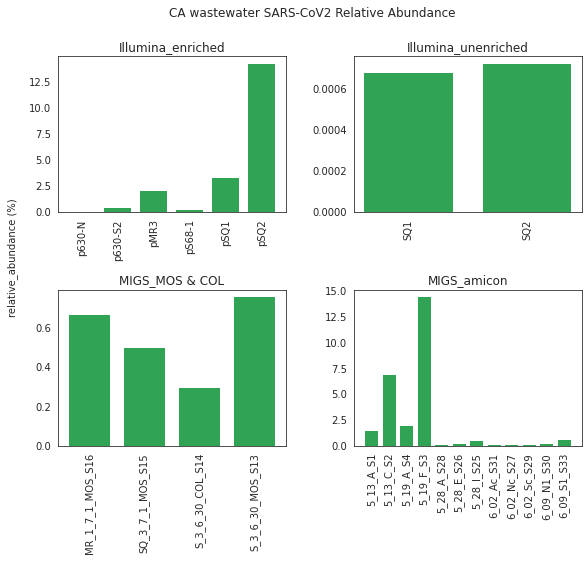

In [446]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(8,6))
fig.tight_layout()
fig.subplots_adjust(hspace=.5,wspace = 0.3)
fig.suptitle('CA wastewater SARS-CoV2 Relative Abundance',y=1.08)

for (name, sgdb), ax in zip(Ndb_covid19.groupby('subgroup'), axes.flatten()):
    simple_stacks_v5(sgdb, 'sample', 'relative_abundance (%)', 'genome', \
                     title="{}".format(name), palette=genome2color,\
                     size=(10,3))
    ax.set(title=name)

ax.get_legend().remove()
fig.text(-0.03, 0.5, 'relative_abundance (%)', va='center', rotation='vertical');

### Only plot the overall top20 most abundant viral genomes

In [465]:
table = defaultdict(list)
for g,gdb in Ndb.groupby('genome'):
    total_relative_abundance_sum = gdb['relative_abundance (%)'].sum()
    
    table['genome'].append(g)
    table['total_relative_abundance'].append(total_relative_abundance_sum)
    
Sdb = pd.DataFrame(table).sort_values('total_relative_abundance',ascending=False).reset_index(drop=True)
Sdb_top20 = Sdb.head(20)
print(len(Sdb))
print(len(Ndb['genome'].unique()))
Sdb_top20

131
131


,genome,total_relative_abundance
0,Severe_acute_respiratory_syndrome_coronavirus_2-tax2697049-GCF_009858895.2_ASM985889v3_genomic.fna,48.267700
1,Tomato_brown_rugose_fruit_virus-tax1761477-GCF_001461485.1_ViralProj304915_genomic.fna,23.457084
2,uncultured_crAssphage-tax1211417-GCF_000922395.1_ViralProj259336_genomic.fna,3.440783
3,Cucumber_green_mottle_mosaic_virus_strain_SH-tax12235-GCF_000849225.1_ViralProj14681_genomic.fna,2.841952
4,Tomato_mosaic_virus-tax12253-GCF_000853705.1_ViralProj14926_genomic.fna,1.418723
5,Human_bocavirus_3_strain_W471-tax638313-GCF_000882855.1_ViralProj37291_genomic.fna,1.396343
6,Human_bocavirus_2c_PK-tax1511882-GCF_000882675.1_ViralProj33891_genomic.fna,1.316658
7,Pepper_mild_mottle_virus_strain_S-tax12239-GCF_000859645.1_ViralProj15148_genomic.fna,0.804248
8,Wuhan_insect_virus_23_strain_WHCCII13263-tax1923727-GCF_001921615.1_ViralMultiSegProj358547_genomic.fna,0.082434
9,Hubei_picorna_like_virus_61_strain_mosHB235903-tax1923144-GCF_001957495.1_ViralProj361635_genomic.fna,0.081347


In [466]:
Ndb3 = Ndb.copy()
Ndb3['genome'] = [x if x in Ndb_top20['genome'].tolist() else 'Other viruses' for x in Ndb3['genome']]
Ndb3 = Ndb3.reset_index(drop=True)
print(len(Ndb3['genome'].unique()))
Ndb3

21


,sample,sample_complete_description,core,method,enrichment,subgroup,genome,length,relative_abundance (%),breadth,coverage,sample_read_bases,sample_reads,popANI_reference,conANI_reference,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,divergent_site_count,reads_unfiltered_reads,nucl_diversity,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,coverage_SEM,breadth_minCov,breadth_expected,nucl_diversity_rarefied,iRep,iRep_GC_corrected,linked_SNV_count,SNV_distance_mean,r2_mean,d_prime_mean,consensus_divergent_sites,population_divergent_sites,SNS_count,SNV_count
0,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Tomato_mosaic_virus-tax12253-GCF_000853705.1_ViralProj14926_genomic.fna,6383.0,0.116825,0.436002,0.950337,6107540,82174,1.000000,0.995833,48,67,0.974626,1.0,136,0.003333,1.0,1.0,0,1.602238,0.020378,0.037600,0.567921,0.000000,NaN,False,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0
1,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Tomato_brown_rugose_fruit_virus-tax1761477-GCF_001461485.1_ViralProj304915_genomic.fna,6393.0,1.591744,0.936806,13.321758,6107540,82174,0.999802,0.999207,654,743,0.990614,33.0,1524,0.004306,1.0,1.0,11,11.393603,0.144792,0.788675,0.999992,0.000000,1.607168,False,20.0,7.950000,0.515256,0.971970,4.0,1.0,1.0,32.0
2,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_2-tax2697049-GCF_009858895.2_ASM985889v3_genomic.fna,29903.0,1.445713,0.704979,2.508344,6107540,82174,0.999827,0.999482,594,662,0.988274,8.0,1377,0.004077,1.0,1.0,1,3.323712,0.019285,0.193860,0.890832,0.000000,NaN,False,NaN,NaN,NaN,NaN,3.0,1.0,1.0,7.0
3,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Pepper_mild_mottle_virus_strain_S-tax12239-GCF_000859645.1_ViralProj15148_genomic.fna,6357.0,0.058413,0.339626,0.495989,6107540,82174,0.000000,0.000000,24,30,0.974398,0.0,61,NaN,1.0,1.0,0,0.776961,0.009903,0.000000,0.354647,NaN,NaN,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Cucumber_green_mottle_mosaic_virus_strain_SH-tax12235-GCF_000849225.1_ViralProj14681_genomic.fna,6424.0,0.029206,0.149440,0.259496,6107540,82174,1.000000,1.000000,12,13,0.981476,0.0,26,0.000000,1.0,1.0,0,0.770032,0.009761,0.008095,0.204779,0.000000,NaN,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,pSQ2,pSQ2_ILLUMINA,ILLUMINA,MOS & COL,enriched,Illumina_enriched,Severe_acute_respiratory_syndrome_coronavirus_2-tax2697049-GCF_009858895.2_ASM985889v3_genomic.fna,29903.0,14.236542,0.701970,4979.995853,1010081054,14005704,0.998414,0.998126,996964,1043166,0.997563,72.0,3061737,0.001374,1.0,1.0,2962,6815.093249,39.543851,0.695984,1.000000,0.001237,2.546182,False,57.0,44.666667,0.517487,0.904007,39.0,33.0,33.0,39.0
689,pSQ2,pSQ2_ILLUMINA,ILLUMINA,MOS & COL,enriched,Illumina_enriched,Tomato_brown_rugose_fruit_virus-tax1761477-GCF_001461485.1_ViralProj304915_genomic.fna,6393.0,0.028374,0.877366,45.930862,1010081054,14005704,0.998573,0.997681,1987,2632,0.997079,30.0,5454,0.001613,1.0,1.0,37,43.645683,0.554659,0.877053,1.000000,0.001194,NaN,False,6.0,6.166667,0.573476,1.000000,13.0,8.0,8.0,22.0
690,pSQ2,pSQ2_ILLUMINA,ILLUMINA,MOS & COL,enriched,Illumina_enriched,Pepper_mild_mottle_virus_strain_S-tax12239-GCF_000859645.1_ViralProj15148_genomic.fna,6357.0,0.001885,0.229353,3.068429,1010081054,14005704,0.991555,0.991555,132,214,0.991006,14.0,475,0.000455,1.0,1.0,0,6.690919,0.085278,0.223533,0.933425,0.000000,NaN,False,1.0,46.000000,1.000000,1.000000,12.0,12.0,12.0,2.0
691,pSQ2,pSQ2_ILLUMINA,ILLUMINA,MOS & COL,enriched,Illumina_enriched,uncultured_crAssphage-tax1211417-GCF_000922395.1_ViralProj259336_genomic.fna,97065.0,0.011467,0.122907,1.223974,1010081054,14005704,0.987179,0.986958,803,1006,0.985908,125.0,2573,0.000986,1.0,1.0,0,4.188498,0.013458,0.093216,0.660665,0.000000,NaN,False,1.0,10

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


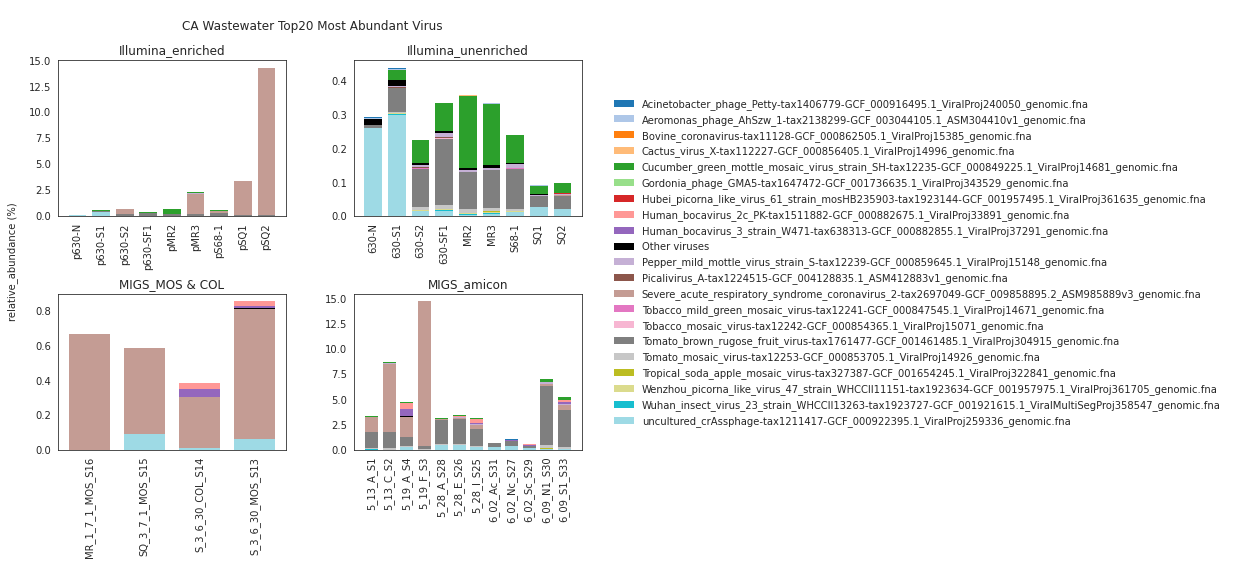

In [467]:
colors_top20 = []
for i,c in enumerate(plt.get_cmap('tab20').colors):
    colors_top20.append(c)
colors_top20.append('black')

genome2color_top20 = dict(zip(Sdb_top20.sort_values('genome')['genome'].tolist()+['Other viruses'], colors_top20))

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(8,6))
fig.tight_layout()
fig.subplots_adjust(hspace=.5,wspace = 0.3)
fig.suptitle('CA Wastewater Top20 Most Abundant Virus',y=1.06)

for (name, sgdb), ax in zip(Ndb3.groupby('subgroup'), axes.flatten()):
    simple_stacks_v5(sgdb, 'sample', 'relative_abundance (%)', 'genome', \
                     title="{}".format(name), palette=genome2color_top20,\
                     size=(10,3),save='/groups/banfield/projects/human/data3/clou/wastewater/Figure/CA_Wastewater_Top20_Most_Abundant_Virus')
    ax.set(title=name)
ax.get_legend().remove()

handles = []
labels = []
for ax in fig.axes:
    axHandles, axLabels = ax.get_legend_handles_labels()
    handles.extend(axHandles)
    labels.extend(axLabels)
by_label = dict(zip(labels, handles))

from collections import OrderedDict
by_label_sorted = OrderedDict(sorted(by_label.items())) 
fig.legend(by_label_sorted.values(), by_label_sorted.keys(), loc='center left',bbox_to_anchor=(1.05, 0.7),frameon=False)

fig.text(-0.03, 0.5, 'relative_abundance (%)', va='center', rotation='vertical');

### Plot top15 most abundant viral genomes

In [468]:
table = defaultdict(list)
for g,gdb in Ndb.groupby('genome'):
    total_relative_abundance_sum = gdb['relative_abundance (%)'].sum()
    
    table['genome'].append(g)
    table['total_relative_abundance'].append(total_relative_abundance_sum)
    
Sdb = pd.DataFrame(table).sort_values('total_relative_abundance',ascending=False).reset_index(drop=True)
Sdb_top15 = Sdb.head(15)
print(len(Sdb))
print(len(Ndb['genome'].unique()))
Sdb_top15

131
131


,genome,total_relative_abundance
0,Severe_acute_respiratory_syndrome_coronavirus_2-tax2697049-GCF_009858895.2_ASM985889v3_genomic.fna,48.267700
1,Tomato_brown_rugose_fruit_virus-tax1761477-GCF_001461485.1_ViralProj304915_genomic.fna,23.457084
2,uncultured_crAssphage-tax1211417-GCF_000922395.1_ViralProj259336_genomic.fna,3.440783
3,Cucumber_green_mottle_mosaic_virus_strain_SH-tax12235-GCF_000849225.1_ViralProj14681_genomic.fna,2.841952
4,Tomato_mosaic_virus-tax12253-GCF_000853705.1_ViralProj14926_genomic.fna,1.418723
5,Human_bocavirus_3_strain_W471-tax638313-GCF_000882855.1_ViralProj37291_genomic.fna,1.396343
6,Human_bocavirus_2c_PK-tax1511882-GCF_000882675.1_ViralProj33891_genomic.fna,1.316658
7,Pepper_mild_mottle_virus_strain_S-tax12239-GCF_000859645.1_ViralProj15148_genomic.fna,0.804248
8,Wuhan_insect_virus_23_strain_WHCCII13263-tax1923727-GCF_001921615.1_ViralMultiSegProj358547_genomic.fna,0.082434
9,Hubei_picorna_like_virus_61_strain_mosHB235903-tax1923144-GCF_001957495.1_ViralProj361635_genomic.fna,0.081347


In [470]:
Ndb4 = Ndb.copy()
Ndb4['genome'] = [x if x in Sdb_top15['genome'].tolist() else 'Other viruses' for x in Ndb4['genome']]
Ndb4 = Ndb4.reset_index(drop=True)
print(len(Ndb4['genome'].unique()))
Ndb4

16


,sample,sample_complete_description,core,method,enrichment,subgroup,genome,length,relative_abundance (%),breadth,coverage,sample_read_bases,sample_reads,popANI_reference,conANI_reference,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,divergent_site_count,reads_unfiltered_reads,nucl_diversity,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,coverage_SEM,breadth_minCov,breadth_expected,nucl_diversity_rarefied,iRep,iRep_GC_corrected,linked_SNV_count,SNV_distance_mean,r2_mean,d_prime_mean,consensus_divergent_sites,population_divergent_sites,SNS_count,SNV_count
0,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Tomato_mosaic_virus-tax12253-GCF_000853705.1_ViralProj14926_genomic.fna,6383.0,0.116825,0.436002,0.950337,6107540,82174,1.000000,0.995833,48,67,0.974626,1.0,136,0.003333,1.0,1.0,0,1.602238,0.020378,0.037600,0.567921,0.000000,NaN,False,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0
1,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Tomato_brown_rugose_fruit_virus-tax1761477-GCF_001461485.1_ViralProj304915_genomic.fna,6393.0,1.591744,0.936806,13.321758,6107540,82174,0.999802,0.999207,654,743,0.990614,33.0,1524,0.004306,1.0,1.0,11,11.393603,0.144792,0.788675,0.999992,0.000000,1.607168,False,20.0,7.950000,0.515256,0.971970,4.0,1.0,1.0,32.0
2,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Severe_acute_respiratory_syndrome_coronavirus_2-tax2697049-GCF_009858895.2_ASM985889v3_genomic.fna,29903.0,1.445713,0.704979,2.508344,6107540,82174,0.999827,0.999482,594,662,0.988274,8.0,1377,0.004077,1.0,1.0,1,3.323712,0.019285,0.193860,0.890832,0.000000,NaN,False,NaN,NaN,NaN,NaN,3.0,1.0,1.0,7.0
3,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Pepper_mild_mottle_virus_strain_S-tax12239-GCF_000859645.1_ViralProj15148_genomic.fna,6357.0,0.058413,0.339626,0.495989,6107540,82174,0.000000,0.000000,24,30,0.974398,0.0,61,NaN,1.0,1.0,0,0.776961,0.009903,0.000000,0.354647,NaN,NaN,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,5_13_A_S1,5_13_A_S1_MIGS,MIGS,amicon,enriched,MIGS_amicon,Cucumber_green_mottle_mosaic_virus_strain_SH-tax12235-GCF_000849225.1_ViralProj14681_genomic.fna,6424.0,0.029206,0.149440,0.259496,6107540,82174,1.000000,1.000000,12,13,0.981476,0.0,26,0.000000,1.0,1.0,0,0.770032,0.009761,0.008095,0.204779,0.000000,NaN,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,pSQ2,pSQ2_ILLUMINA,ILLUMINA,MOS & COL,enriched,Illumina_enriched,Severe_acute_respiratory_syndrome_coronavirus_2-tax2697049-GCF_009858895.2_ASM985889v3_genomic.fna,29903.0,14.236542,0.701970,4979.995853,1010081054,14005704,0.998414,0.998126,996964,1043166,0.997563,72.0,3061737,0.001374,1.0,1.0,2962,6815.093249,39.543851,0.695984,1.000000,0.001237,2.546182,False,57.0,44.666667,0.517487,0.904007,39.0,33.0,33.0,39.0
689,pSQ2,pSQ2_ILLUMINA,ILLUMINA,MOS & COL,enriched,Illumina_enriched,Tomato_brown_rugose_fruit_virus-tax1761477-GCF_001461485.1_ViralProj304915_genomic.fna,6393.0,0.028374,0.877366,45.930862,1010081054,14005704,0.998573,0.997681,1987,2632,0.997079,30.0,5454,0.001613,1.0,1.0,37,43.645683,0.554659,0.877053,1.000000,0.001194,NaN,False,6.0,6.166667,0.573476,1.000000,13.0,8.0,8.0,22.0
690,pSQ2,pSQ2_ILLUMINA,ILLUMINA,MOS & COL,enriched,Illumina_enriched,Pepper_mild_mottle_virus_strain_S-tax12239-GCF_000859645.1_ViralProj15148_genomic.fna,6357.0,0.001885,0.229353,3.068429,1010081054,14005704,0.991555,0.991555,132,214,0.991006,14.0,475,0.000455,1.0,1.0,0,6.690919,0.085278,0.223533,0.933425,0.000000,NaN,False,1.0,46.000000,1.000000,1.000000,12.0,12.0,12.0,2.0
691,pSQ2,pSQ2_ILLUMINA,ILLUMINA,MOS & COL,enriched,Illumina_enriched,uncultured_crAssphage-tax1211417-GCF_000922395.1_ViralProj259336_genomic.fna,97065.0,0.011467,0.122907,1.223974,1010081054,14005704,0.987179,0.986958,803,1006,0.985908,125.0,2573,0.000986,1.0,1.0,0,4.188498,0.013458,0.093216,0.660665,0.000000,NaN,False,1.0,10

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


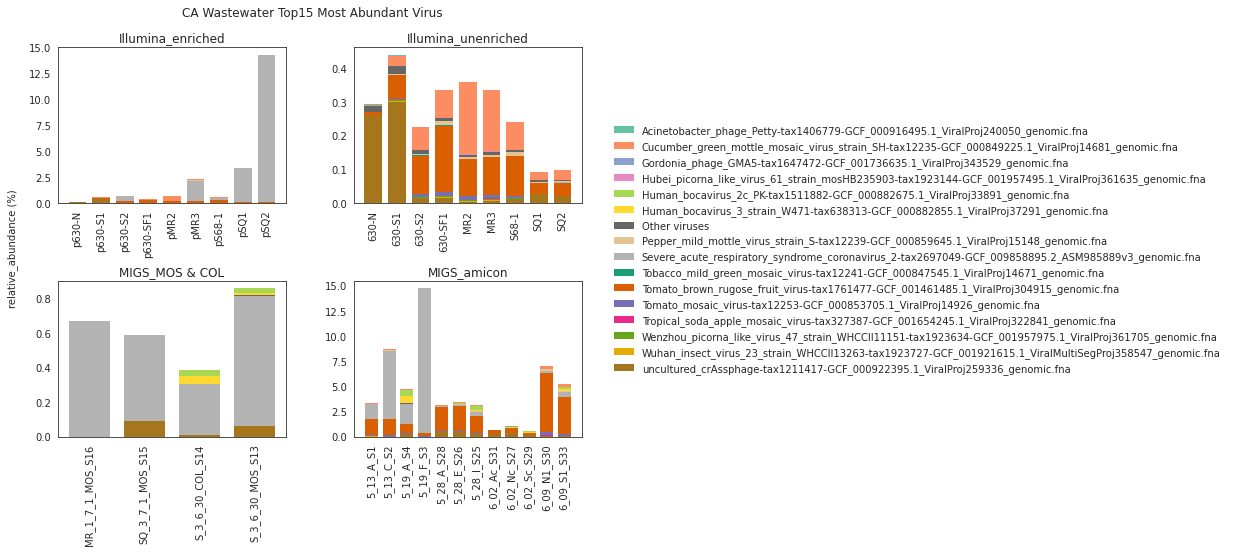

In [476]:
colors_top15 = []
for i,c in enumerate(plt.get_cmap('Set2').colors):
    colors_top15.append(c)
for i,c in enumerate(plt.get_cmap('Dark2').colors):
    colors_top15.append(c)

genome2color_top15 = dict(zip(Sdb_top15.sort_values('genome')['genome'].tolist()+['Other viruses'], colors_top15))

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(8,6))
fig.tight_layout()
fig.subplots_adjust(hspace=.5,wspace = 0.3)
fig.suptitle('CA Wastewater Top15 Most Abundant Virus',y=1.06)

for (name, sgdb), ax in zip(Ndb4.groupby('subgroup'), axes.flatten()):
    simple_stacks_v5(sgdb, 'sample', 'relative_abundance (%)', 'genome', \
                     title="{}".format(name), palette=genome2color_top15,\
                     size=(10,3),save='/groups/banfield/projects/human/data3/clou/wastewater/Figure/CA_Wastewater_Top15_Most_Abundant_Virus')
    ax.set(title=name)
ax.get_legend().remove()

handles = []
labels = []
for ax in fig.axes:
    axHandles, axLabels = ax.get_legend_handles_labels()
    handles.extend(axHandles)
    labels.extend(axLabels)
by_label = dict(zip(labels, handles))

from collections import OrderedDict
by_label_sorted = OrderedDict(sorted(by_label.items())) 
fig.legend(by_label_sorted.values(), by_label_sorted.keys(), loc='center left',bbox_to_anchor=(1.05, 0.7),frameon=False)

fig.text(-0.03, 0.5, 'relative_abundance (%)', va='center', rotation='vertical');

### Plot SARS-CoV2 again with the same color scheme as above

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


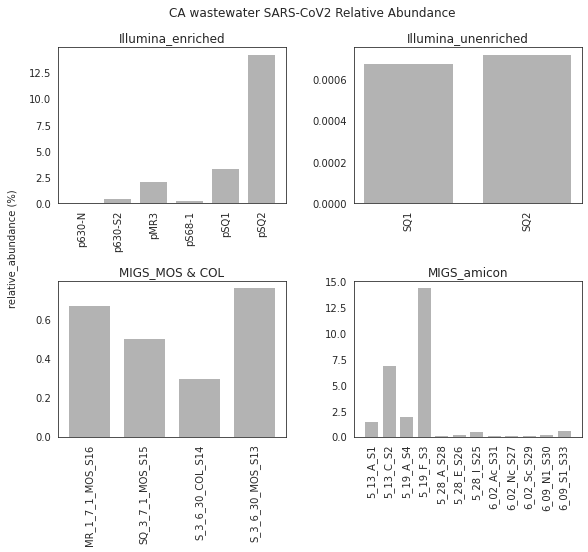

In [477]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(8,6))
fig.tight_layout()
fig.subplots_adjust(hspace=.5,wspace = 0.3)
fig.suptitle('CA wastewater SARS-CoV2 Relative Abundance',y=1.06)

for (name, sgdb), ax in zip(Ndb_covid19.groupby('subgroup'), axes.flatten()):
    simple_stacks_v5(sgdb, 'sample', 'relative_abundance (%)', 'genome', \
                     title="{}".format(name), palette=genome2color_top15,\
                     size=(10,3),save='/groups/banfield/projects/human/data3/clou/wastewater/Figure/CA_Wastewater_SARS-CoV2_Relative_Abundance')
    ax.set(title=name)

ax.get_legend().remove()
fig.text(-0.03, 0.5, 'relative_abundance (%)', va='center', rotation='vertical');

### Only looking at coronavirus OC43 strain 

In [454]:
OC43 = Ndb_raw[Ndb_raw['genome'].str.contains('OC43')]
OC43['genome'].unique()

array(['Human_coronavirus_OC43_strain_ATCC_VR_759-tax31631-GCF_003972325.1_ASM397232v1_genomic.fna'],
      dtype=object)

In [455]:
print(OC43['subgroup'].unique())
print(len(OC43['sample'].unique()))

['MIGS_amicon' 'MIGS_MOS & COL' 'Illumina_enriched']
8


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


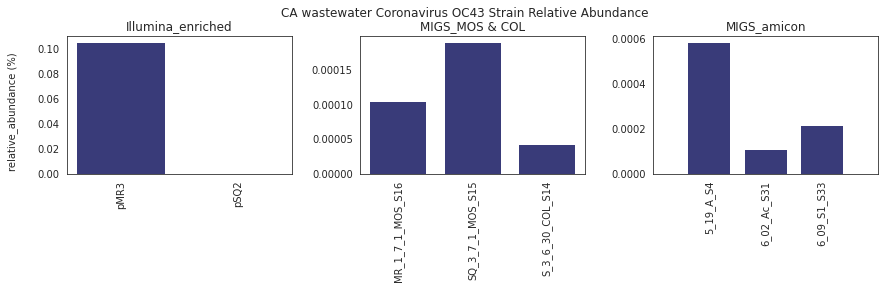

In [456]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(12,2.5))
fig.tight_layout()
fig.subplots_adjust(wspace = 0.3)
fig.suptitle('CA wastewater Coronavirus OC43 Strain Relative Abundance',y=1.08)

for (name, sgdb), ax in zip(OC43.groupby('subgroup'), axes.flatten()):
    simple_stacks_v5(sgdb, 'sample', 'relative_abundance (%)', 'genome', \
                     title="{}".format(name),\
                     size=(10,3),save='/groups/banfield/projects/human/data3/clou/wastewater/Figure/CA_Wastewater_OC43_Relative_Abundance')
    ax.set(title=name)
ax.get_legend().remove()
fig.text(-0.03, 0.5, 'relative_abundance (%)', va='center', rotation='vertical');

### Only look at bovine virus

In [457]:
bovine_virus = Ndb[Ndb['genome'].str.contains('Bovine')]
print(bovine_virus['genome'].unique())
print(bovine_virus['subgroup'].unique())
print((bovine_virus['sample'].unique()))

['Bovine_coronavirus-tax11128-GCF_000862505.1_ViralProj15385_genomic.fna']
['MIGS_amicon']
['6_09_S1_S33']


In [458]:
bovine_virus_raw = Ndb_raw[Ndb_raw['genome'].str.contains('Bovine_coronavirus')].sort_values('breadth',ascending=False)
print(bovine_virus_raw['genome'].unique())
print(len(bovine_virus_raw['subgroup'].unique()))
print(len(bovine_virus_raw['sample'].unique()))

['Bovine_coronavirus-tax11128-GCF_000862505.1_ViralProj15385_genomic.fna']
4
20


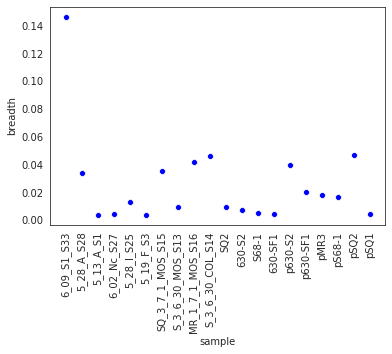

In [459]:
sns.scatterplot(x='sample',y='breadth',data=bovine_virus_raw.sort_values('subgroup',ascending=False),color='blue')
plt.xticks(rotation=90);

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


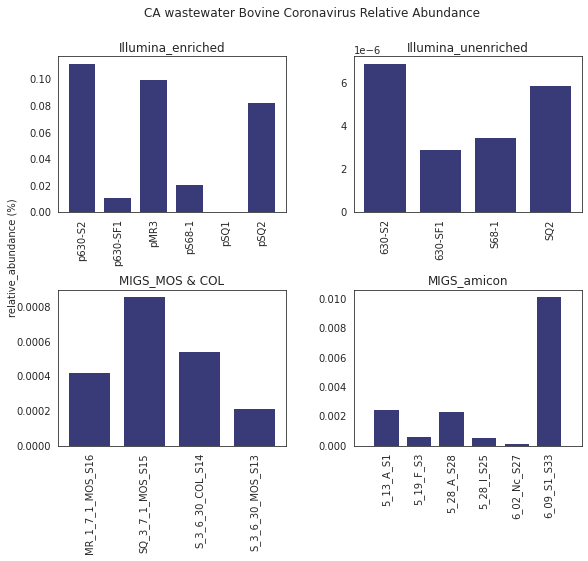

In [460]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(8,6))
fig.tight_layout()
fig.subplots_adjust(hspace=.5,wspace = 0.3)
fig.suptitle('CA wastewater Bovine Coronavirus Relative Abundance',y=1.08)

for (name, sgdb), ax in zip(bovine_virus_raw.groupby('subgroup'), axes.flatten()):
    simple_stacks_v5(sgdb, 'sample', 'relative_abundance (%)', 'genome', \
                     title="{}".format(name),\
                     size=(10,3),save='/groups/banfield/projects/human/data3/clou/wastewater/Figure/CA_Wastewater_Bovine_Coronavirus_Relative_Abundance')
    ax.set(title=name)
ax.get_legend().remove()
fig.text(-0.03, 0.5, 'relative_abundance (%)', va='center', rotation='vertical');

### Only looking at viral genomes that are almost complete (breadth >= 0.95)

In [461]:
Ndb_complete_genomes_only = Ndb[Ndb['breadth']>=0.95]
Ndb4 = Ndb_complete_genomes_only.copy()

In [462]:
print(len(Ndb['genome'].unique()))
print(len(Ndb2['genome'].unique()))
print(len(Ndb4['genome'].unique()))
print()
print(len(Ndb['sample'].unique()))
print(len(Ndb2['sample'].unique()))
print(len(Ndb4['sample'].unique()))

131
37
11

34
34
29


In [463]:
colors_complete_genomes = []
for i,c in enumerate(plt.get_cmap('tab20').colors):
    colors_complete_genomes.append(c)


genome2color_complete_genomes = dict(zip(Ndb4.sort_values('genome')['genome'].unique().tolist(), colors_complete_genomes))
print(len(Ndb4['genome'].unique()))
Ndb4['subgroup'] = ["MIGS_"+x if y == 'MIGS' else "Illumina_"+z for x,y,z in zip(Ndb4['method'],Ndb4['core'],Ndb4['enrichment'])]

11


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


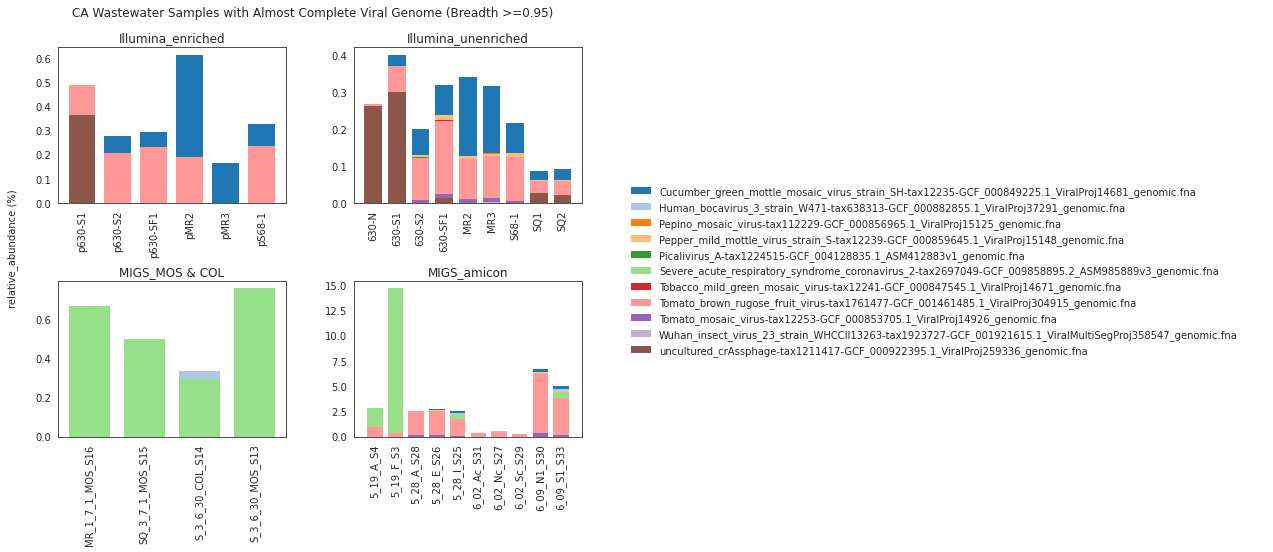

In [464]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(8,6))
fig.tight_layout()
fig.subplots_adjust(hspace=.5,wspace = 0.3)
fig.suptitle('CA Wastewater Samples with Almost Complete Viral Genome (Breadth >=0.95)',y=1.06)

for (name, sgdb), ax in zip(Ndb4.groupby('subgroup'), axes.flatten()):
    simple_stacks_v5(sgdb, 'sample', 'relative_abundance (%)', 'genome', \
                     title="{}".format(name), palette=genome2color_complete_genomes,\
                     size=(10,3),save='/groups/banfield/projects/human/data3/clou/wastewater/Figure/CA_Wastewater_Almost_Complete_Viral_Genomes_Relative_Abundance')
    ax.set(title=name)
ax.get_legend().remove()

handles = []
labels = []
for ax in fig.axes:
    axHandles, axLabels = ax.get_legend_handles_labels()
    handles.extend(axHandles)
    labels.extend(axLabels)
by_label = dict(zip(labels, handles))

from collections import OrderedDict
by_label_sorted = OrderedDict(sorted(by_label.items())) 
fig.legend(by_label_sorted.values(), by_label_sorted.keys(), loc='center left',bbox_to_anchor=(1.08, 0.65),frameon=False)

fig.text(-0.03, 0.5, 'relative_abundance (%)', va='center', rotation='vertical');